In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd

In [40]:
# ----------------------------
# Load and Clean NGL Data
# ----------------------------

def load_ngl_data(filepath):
    # Load all sheets dynamically, starting from the correct header row
    xl = pd.ExcelFile(filepath)
    sheets = xl.sheet_names
    print(f"Available Sheets: {sheets}")
    
    ngl_data = {}
    for sheet in sheets:
        df = xl.parse(sheet, header=4)  # Start from row 5 (header=4)
        df = df.rename(columns={df.columns[0]: 'Date'})  # Rename the date column
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')  # Convert date column
        df = df.dropna(subset=['Date'])  # Drop rows where date is NaT
        
        # Keep only the first two contracts (NG1 and NG2) for now
        df = df[['Date', df.columns[1], df.columns[2]]]
        df.columns = ['Date', 'NG1', 'NG2']
        
        ngl_data[sheet] = df
    
    return ngl_data

# File path
ngl_filepath = '/Users/markbogorad/Desktop/NYU_MFE/Semester_2/1.2_Trading_Energy_Derivatives_MATH_GA_2800/Oil_Project/Systematic_Energy_Trading/Data/NGLs.xlsx'

# Load the data
ngl_datasets = load_ngl_data(ngl_filepath)

# Display one of the datasets to verify
for key, df in ngl_datasets.items():
    print(f"\nFirst few rows of sheet: {key}")
    print(df.head())
    break  # Display only the first sheet for now



Available Sheets: ['NG', 'CAP', 'BAP', 'DAE', 'IBD', 'MMB', 'PCW', 'PGP']

First few rows of sheet: NG
        Date    NG1    NG2
0 2011-07-07  4.133  4.138
1 2011-07-08  4.205  4.204
2 2011-07-11  4.288  4.277
3 2011-07-12  4.333  4.312
4 2011-07-13  4.403  4.387


In [41]:
# ----------------------------
# 2. Define EOM Roll Calendar (No Expiry)
# ----------------------------

def define_eom_roll_calendar(df):
    # Mark roll days as the last business day of each month
    df['Roll'] = 0
    df.loc[df['Date'] == df['Date'] + MonthEnd(0), 'Roll'] = 1
    
    # Define actions based on roll
    df['Action'] = 'Hold'
    df.loc[df.index[0], 'Action'] = 'Buy'                    # Initial buy
    df.loc[df['Roll'] == 1, 'Action'] = 'Sell & Buy'         # Roll day
    df.loc[df.index[-1], 'Action'] = 'Sell'                  # Final sell

    return df


In [42]:
def calculate_eom_rolling_futures(df, transaction_cost=0.01):
    rolling_futures = []
    rolling_pnl = []
    cumulative_costs = []
    total_cost = 0

    for idx in range(len(df)):
        t_cost = 0

        if idx == 0:
            t_cost = transaction_cost
            total_cost += t_cost
            rolling_futures.append(df.loc[idx, 'NG1'] - t_cost)
            rolling_pnl.append(0)
        
        else:
            if df.loc[idx, 'Roll'] == 1:
                change = df.loc[idx, 'NG2'] - df.loc[idx - 1, 'NG1']
                t_cost = 2 * transaction_cost
            else:
                change = df.loc[idx, 'NG1'] - df.loc[idx - 1, 'NG1']
            
            total_cost += t_cost
            adjusted_value = rolling_futures[-1] + change - t_cost
            rolling_futures.append(adjusted_value)
            rolling_pnl.append(change - t_cost)

        cumulative_costs.append(total_cost)

    df['Rolling Futures PnL'] = rolling_pnl
    df['Rolling Futures'] = rolling_futures
    df['Cumulative Transaction Costs'] = cumulative_costs

    return df

In [43]:
# ----------------------------
# 4. Apply to Each Sheet
# ----------------------------

# File path
ngl_filepath = '/Users/markbogorad/Desktop/NYU_MFE/Semester_2/1.2_Trading_Energy_Derivatives_MATH_GA_2800/Oil_Project/Systematic_Energy_Trading/Data/NGLs.xlsx'

# Load data
ngl_datasets = load_ngl_data(ngl_filepath)

# Process each sheet
for name, df in ngl_datasets.items():
    print(f"\nProcessing Sheet: {name}")
    df = define_eom_roll_calendar(df)
    df = calculate_eom_rolling_futures(df, transaction_cost=0.01)
    
    # Display first few rows for validation
    display(df.head(10))
    
    # Optional: Save the processed data
    # df.to_csv(f'processed_{name}.csv', index=False)

Available Sheets: ['NG', 'CAP', 'BAP', 'DAE', 'IBD', 'MMB', 'PCW', 'PGP']

Processing Sheet: NG


,Date,NG1,NG2,Roll,Action,Rolling Futures PnL,Rolling Futures,Cumulative Transaction Costs
0,2011-07-07,4.133,4.138,0,Buy,0.000,4.123,0.01
1,2011-07-08,4.205,4.204,0,Hold,0.072,4.195,0.01
2,2011-07-11,4.288,4.277,0,Hold,0.083,4.278,0.01
3,2011-07-12,4.333,4.312,0,Hold,0.045,4.323,0.01
4,2011-07-13,4.403,4.387,0,Hold,0.070,4.393,0.01
5,2011-07-14,4.378,4.358,0,Hold,-0.025,4.368,0.01
6,2011-07-15,4.546,4.520,0,Hold,0.168,4.536,0.01
7,2011-07-18,4.546,4.524,0,Hold,0.000,4.536,0.01
8,2011-07-19,4.533,4.511,0,Hold,-0.013,4.523,0.01
9,2011-07-20,4.500,4.469,0,Hold,-0.033,4.490,0.01



Processing Sheet: CAP


,Date,NG1,NG2,Roll,Action,Rolling Futures PnL,Rolling Futures,Cumulative Transaction Costs
0,2011-07-07,0.81141,0.80391,0,Buy,0.00000,0.80141,0.01
1,2011-07-08,0.80528,0.79750,0,Hold,-0.00613,0.79528,0.01
2,2011-07-11,0.80514,0.79781,0,Hold,-0.00014,0.79514,0.01
3,2011-07-12,0.80509,0.79906,0,Hold,-0.00005,0.79509,0.01
4,2011-07-13,0.80294,0.79656,0,Hold,-0.00215,0.79294,0.01
5,2011-07-14,0.80140,0.79344,0,Hold,-0.00154,0.79140,0.01
6,2011-07-15,0.80644,0.80188,0,Hold,0.00504,0.79644,0.01
7,2011-07-18,0.80437,0.79781,0,Hold,-0.00207,0.79437,0.01
8,2011-07-19,0.80514,0.80000,0,Hold,0.00077,0.79514,0.01
9,2011-07-20,0.80506,0.79875,0,Hold,-0.00008,0.79506,0.01



Processing Sheet: BAP


,Date,NG1,NG2,Roll,Action,Rolling Futures PnL,Rolling Futures,Cumulative Transaction Costs
0,2011-07-11,1.51947,1.52708,0,Buy,0.00000,1.50947,0.01
1,2011-07-12,1.53045,1.54417,0,Hold,0.01098,1.52045,0.01
2,2011-07-13,1.52457,1.53583,0,Hold,-0.00588,1.51457,0.01
3,2011-07-14,1.51784,1.52458,0,Hold,-0.00673,1.50784,0.01
4,2011-07-15,1.52659,1.53917,0,Hold,0.00875,1.51659,0.01
5,2011-07-18,1.51507,1.51625,0,Hold,-0.01152,1.50507,0.01
6,2011-07-19,1.52253,1.53250,0,Hold,0.00746,1.51253,0.01
7,2011-07-20,1.52172,1.53000,0,Hold,-0.00081,1.51172,0.01
8,2011-07-21,1.52282,1.53208,0,Hold,0.00110,1.51282,0.01
9,2011-07-22,1.52284,1.53375,0,Hold,0.00002,1.51284,0.01



Processing Sheet: DAE


,Date,NG1,NG2,Roll,Action,Rolling Futures PnL,Rolling Futures,Cumulative Transaction Costs
0,2011-07-07,1.86025,1.87656,0,Buy,0.00000,1.85025,0.01
1,2011-07-08,1.86875,1.88875,0,Hold,0.00850,1.85875,0.01
2,2011-07-11,1.85609,1.87750,0,Hold,-0.01266,1.84609,0.01
3,2011-07-12,1.85953,1.88750,0,Hold,0.00344,1.84953,0.01
4,2011-07-13,1.86663,1.88563,0,Hold,0.00710,1.85663,0.01
5,2011-07-14,1.86522,1.87219,0,Hold,-0.00141,1.85522,0.01
6,2011-07-15,1.85780,1.88844,0,Hold,-0.00742,1.84780,0.01
7,2011-07-18,1.86669,1.87063,0,Hold,0.00889,1.85669,0.01
8,2011-07-19,1.85775,1.88813,0,Hold,-0.00894,1.84775,0.01
9,2011-07-20,1.86594,1.89594,0,Hold,0.00819,1.85594,0.01



Processing Sheet: IBD


,Date,NG1,NG2,Roll,Action,Rolling Futures PnL,Rolling Futures,Cumulative Transaction Costs
0,2011-07-11,2.01269,1.99313,0,Buy,0.00000,2.00269,0.01
1,2011-07-12,2.01788,2.00813,0,Hold,0.00519,2.00788,0.01
2,2011-07-13,2.01541,2.00500,0,Hold,-0.00247,2.00541,0.01
3,2011-07-14,2.00794,1.99313,0,Hold,-0.00747,1.99794,0.01
4,2011-07-15,2.01916,2.00875,0,Hold,0.01122,2.00916,0.01
5,2011-07-18,2.01044,1.99188,0,Hold,-0.00872,2.00044,0.01
6,2011-07-19,2.02631,2.00938,0,Hold,0.01587,2.01631,0.01
7,2011-07-20,2.03925,2.03750,0,Hold,0.01294,2.02925,0.01
8,2011-07-21,2.03772,2.03000,0,Hold,-0.00153,2.02772,0.01
9,2011-07-22,2.04300,2.04188,0,Hold,0.00528,2.03300,0.01



Processing Sheet: MMB


,Date,NG1,NG2,Roll,Action,Rolling Futures PnL,Rolling Futures,Cumulative Transaction Costs
0,2011-07-11,2.43700,2.44208,0,Buy,0.00000,2.42700,0.01
1,2011-07-12,2.45011,2.46417,0,Hold,0.01311,2.44011,0.01
2,2011-07-13,2.46866,2.49375,0,Hold,0.01855,2.45866,0.01
3,2011-07-14,2.45400,2.47042,0,Hold,-0.01466,2.44400,0.01
4,2011-07-15,2.46254,2.48542,0,Hold,0.00854,2.45254,0.01
5,2011-07-18,2.44613,2.45333,0,Hold,-0.01641,2.43613,0.01
6,2011-07-19,2.45763,2.47833,0,Hold,0.01150,2.44763,0.01
7,2011-07-20,2.46113,2.48708,0,Hold,0.00350,2.45113,0.01
8,2011-07-21,2.45838,2.48250,0,Hold,-0.00275,2.44838,0.01
9,2011-07-22,2.46013,2.48750,0,Hold,0.00175,2.45013,0.01



Processing Sheet: PCW


,Date,NG1,NG2,Roll,Action,Rolling Futures PnL,Rolling Futures,Cumulative Transaction Costs
0,2011-07-07,0.5750,0.57125,0,Buy,0.0000,0.5650,0.01
1,2011-07-08,0.5675,0.56500,0,Hold,-0.0075,0.5575,0.01
2,2011-07-11,0.5675,0.56500,0,Hold,0.0000,0.5575,0.01
3,2011-07-12,0.5675,0.56500,0,Hold,0.0000,0.5575,0.01
4,2011-07-13,0.5600,0.55750,0,Hold,-0.0075,0.5500,0.01
5,2011-07-14,0.5675,0.56625,0,Hold,0.0075,0.5575,0.01
6,2011-07-15,0.5800,0.57625,0,Hold,0.0125,0.5700,0.01
7,2011-07-18,0.5900,0.58500,0,Hold,0.0100,0.5800,0.01
8,2011-07-19,0.5950,0.59000,0,Hold,0.0050,0.5850,0.01
9,2011-07-20,0.6025,0.60000,0,Hold,0.0075,0.5925,0.01



Processing Sheet: PGP


,Date,NG1,NG2,Roll,Action,Rolling Futures PnL,Rolling Futures,Cumulative Transaction Costs
0,2011-07-07,0.76125,0.7600,0,Buy,0.00000,0.75125,0.01
1,2011-07-08,0.76125,0.7600,0,Hold,0.00000,0.75125,0.01
2,2011-07-11,0.76125,0.7600,0,Hold,0.00000,0.75125,0.01
3,2011-07-12,0.77000,0.7775,0,Hold,0.00875,0.76000,0.01
4,2011-07-13,0.77000,0.7750,0,Hold,0.00000,0.76000,0.01
5,2011-07-14,0.77000,0.7750,0,Hold,0.00000,0.76000,0.01
6,2011-07-15,0.77000,0.7750,0,Hold,0.00000,0.76000,0.01
7,2011-07-18,0.77000,0.7750,0,Hold,0.00000,0.76000,0.01
8,2011-07-19,0.77500,0.7750,0,Hold,0.00500,0.76500,0.01
9,2011-07-20,0.77500,0.7750,0,Hold,0.00000,0.76500,0.01


In [44]:
# ----------------------------
# 5. Metrics for Each Sheet
# ----------------------------

def calculate_metrics(df, sheet_name):
    first_value = df['Rolling Futures'].iloc[0]
    last_value = df['Rolling Futures'].iloc[-1]
    
    pnl = (last_value - first_value) * 100 * 1000
    total_costs = df['Cumulative Transaction Costs'].iloc[-1] * 100 * 1000
    
    metrics = {
        'Sheet': sheet_name,
        'Rolling Futures PnL': pnl,
        'Total Transaction Costs': total_costs
    }

    print(f"\nMetrics for {sheet_name}:")
    for key, value in metrics.items():
        if key != 'Sheet':
            print(f"{key}: ${value:,.2f}")
    
    return metrics

# Process and store metrics for each sheet
all_metrics = []

for name, df in ngl_datasets.items():
    metrics = calculate_metrics(df, name)
    all_metrics.append(metrics)

# Convert metrics to DataFrame for summary view
metrics_df = pd.DataFrame(all_metrics)

# Display the consolidated metrics
display(metrics_df)

# Optional: Save metrics to CSV
# metrics_df.to_csv('ngl_metrics_summary.csv', index=False)



Metrics for NG:
Rolling Futures PnL: $454,200.00
Total Transaction Costs: $233,000.00

Metrics for CAP:
Rolling Futures PnL: $-331,944.00
Total Transaction Costs: $233,000.00

Metrics for BAP:
Rolling Futures PnL: $-266,768.00
Total Transaction Costs: $233,000.00

Metrics for DAE:
Rolling Futures PnL: $-329,915.00
Total Transaction Costs: $233,000.00

Metrics for IBD:
Rolling Futures PnL: $-514,663.00
Total Transaction Costs: $233,000.00

Metrics for MMB:
Rolling Futures PnL: $-336,820.00
Total Transaction Costs: $233,000.00

Metrics for PCW:
Rolling Futures PnL: $-319,628.00
Total Transaction Costs: $233,000.00

Metrics for PGP:
Rolling Futures PnL: $-288,505.00
Total Transaction Costs: $233,000.00


,Sheet,Rolling Futures PnL,Total Transaction Costs
0,NG,454200.0,233000.0
1,CAP,-331944.0,233000.0
2,BAP,-266768.0,233000.0
3,DAE,-329915.0,233000.0
4,IBD,-514663.0,233000.0
5,MMB,-336820.0,233000.0
6,PCW,-319628.0,233000.0
7,PGP,-288505.0,233000.0



Metrics for NG:
Rolling Futures PnL: $454,200.00
Total Transaction Costs: $233,000.00


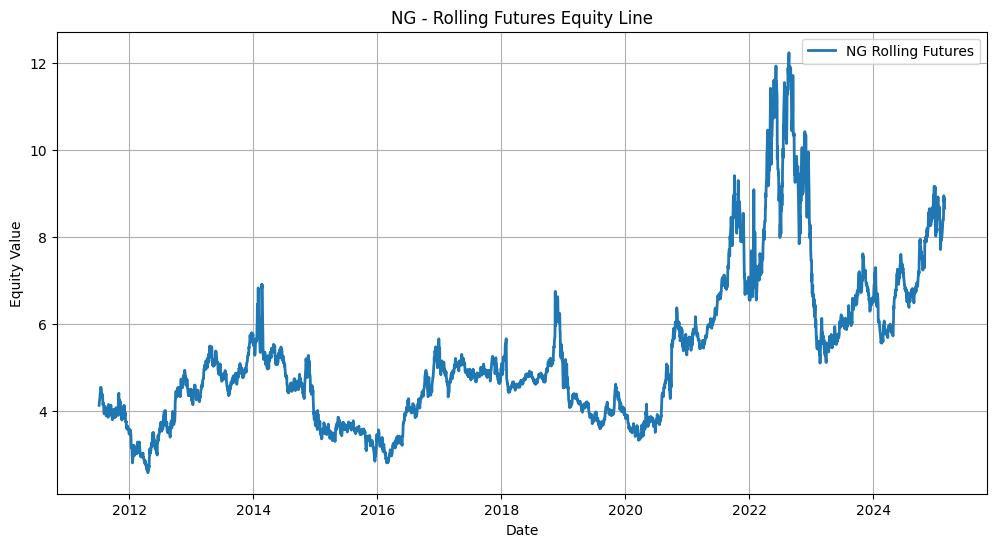


Metrics for CAP:
Rolling Futures PnL: $-331,944.00
Total Transaction Costs: $233,000.00


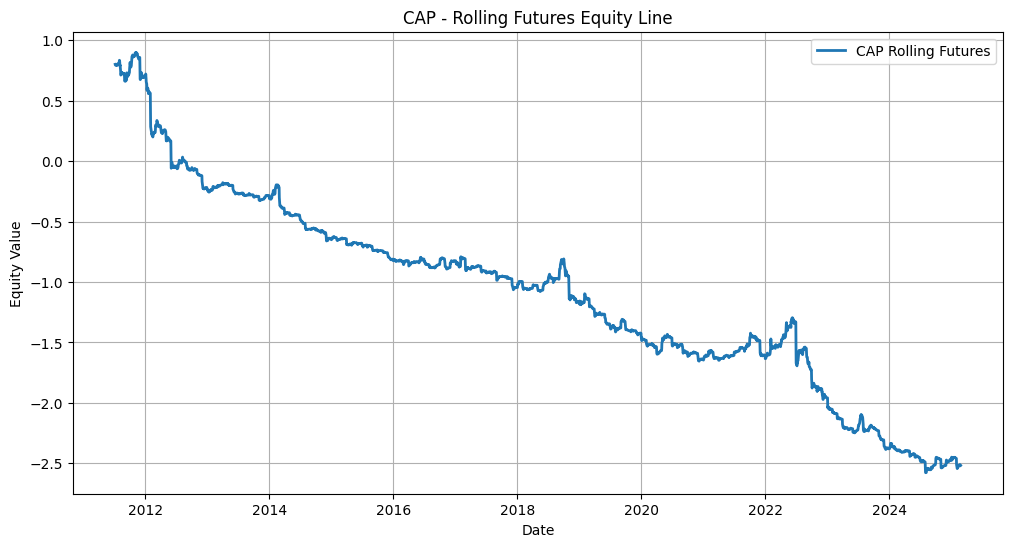


Metrics for BAP:
Rolling Futures PnL: $-266,768.00
Total Transaction Costs: $233,000.00


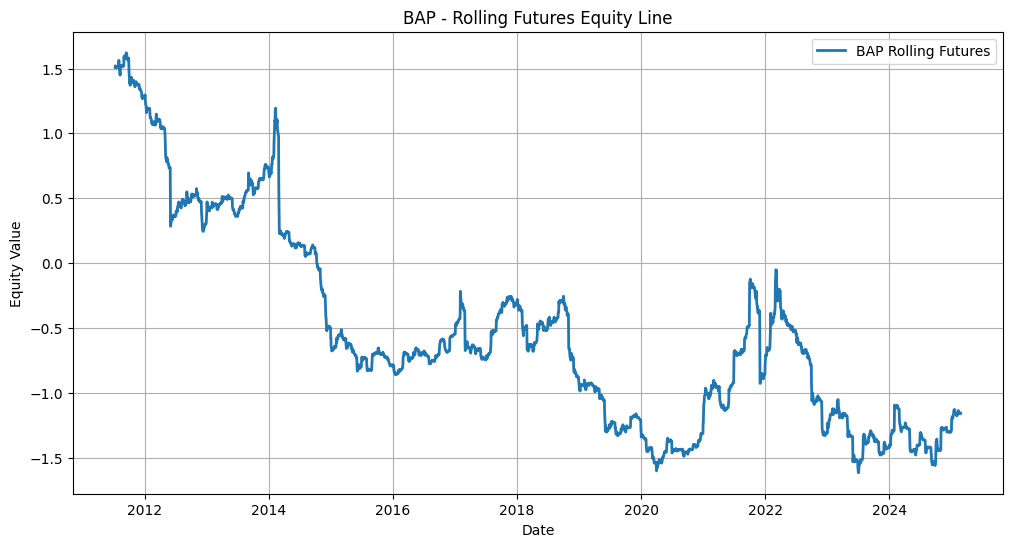


Metrics for DAE:
Rolling Futures PnL: $-329,915.00
Total Transaction Costs: $233,000.00


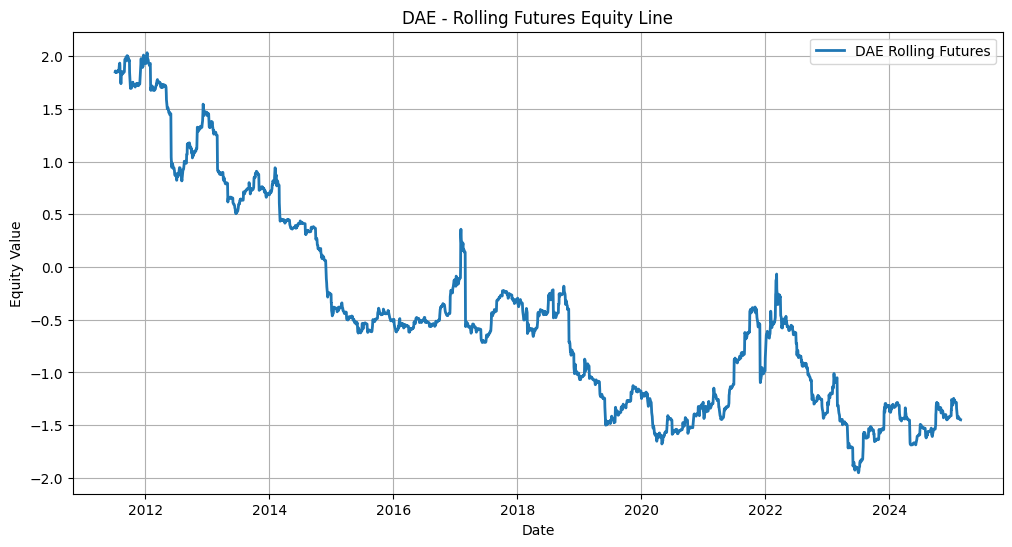


Metrics for IBD:
Rolling Futures PnL: $-514,663.00
Total Transaction Costs: $233,000.00


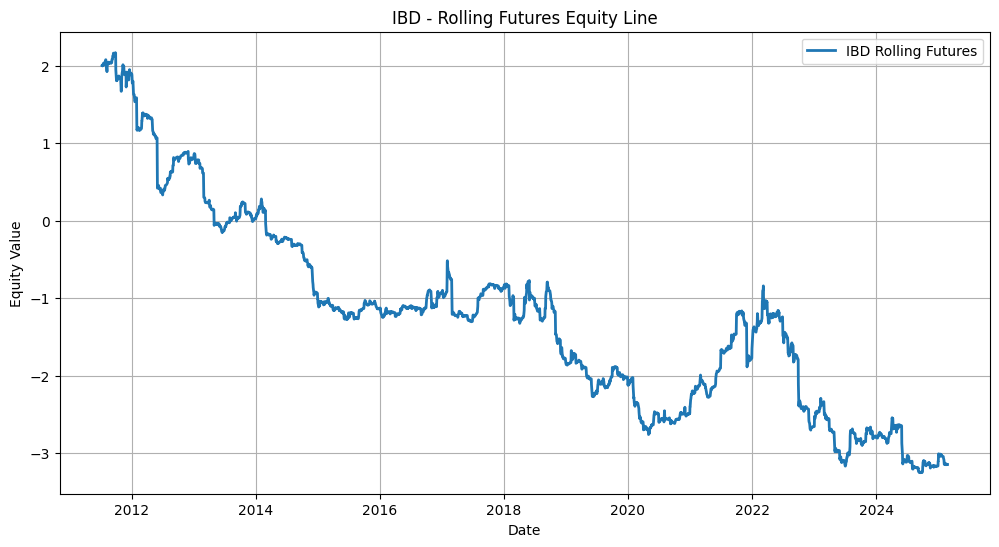


Metrics for MMB:
Rolling Futures PnL: $-336,820.00
Total Transaction Costs: $233,000.00


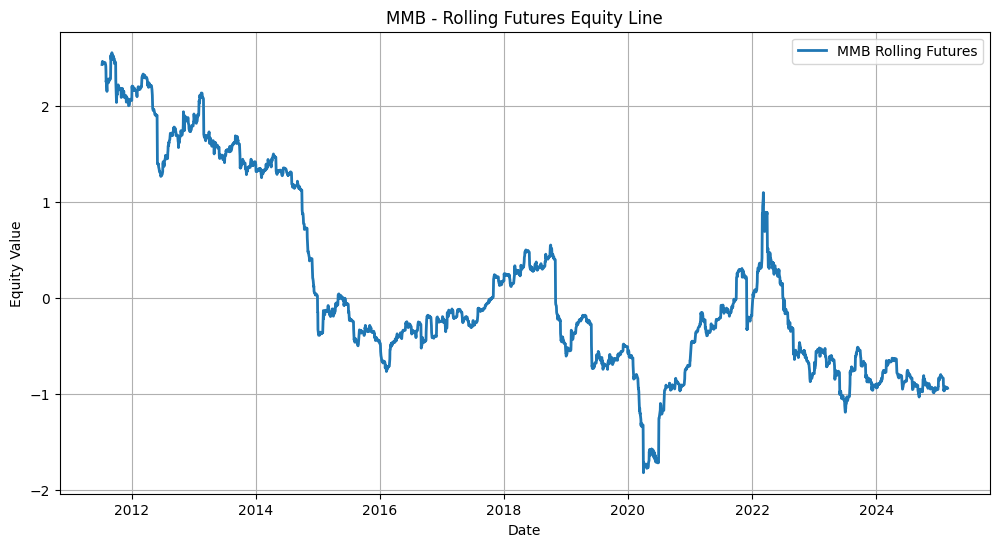


Metrics for PCW:
Rolling Futures PnL: $-319,628.00
Total Transaction Costs: $233,000.00


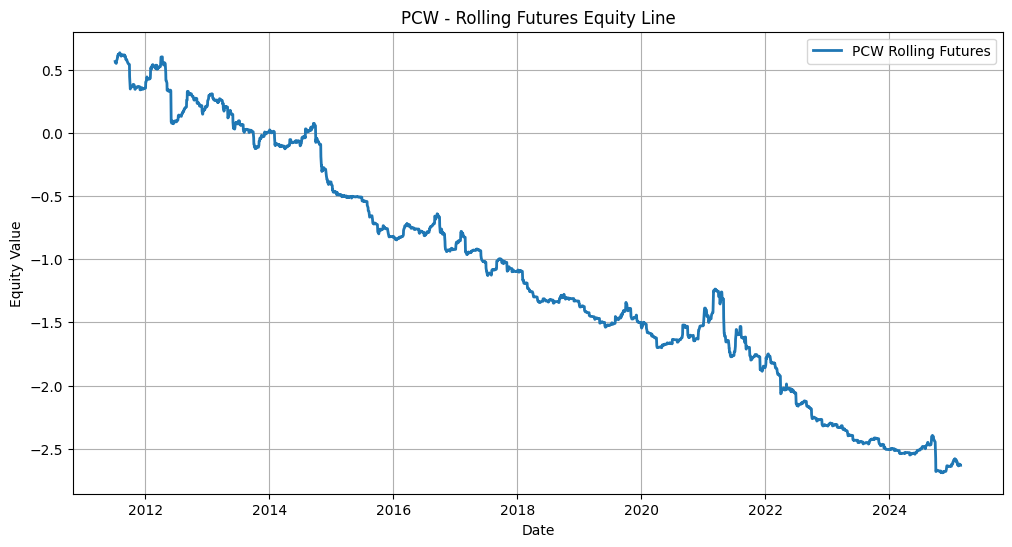


Metrics for PGP:
Rolling Futures PnL: $-288,505.00
Total Transaction Costs: $233,000.00


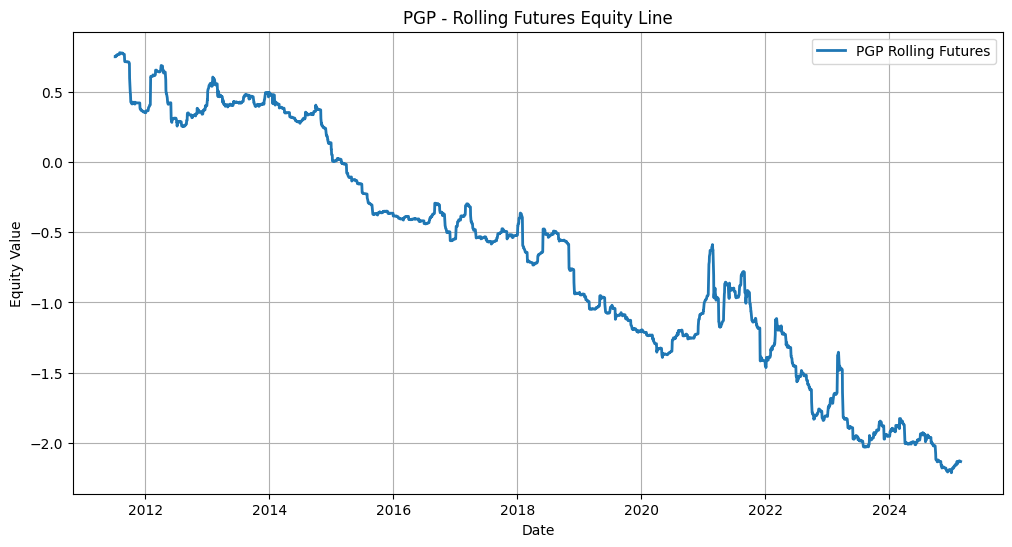

,Sheet,Rolling Futures PnL,Total Transaction Costs
0,NG,454200.0,233000.0
1,CAP,-331944.0,233000.0
2,BAP,-266768.0,233000.0
3,DAE,-329915.0,233000.0
4,IBD,-514663.0,233000.0
5,MMB,-336820.0,233000.0
6,PCW,-319628.0,233000.0
7,PGP,-288505.0,233000.0


In [45]:
import matplotlib.pyplot as plt

# ----------------------------
# 5. Metrics and Plotting for Each Sheet
# ----------------------------

def calculate_metrics_and_plot(df, sheet_name):
    # Metrics Calculation
    first_value = df['Rolling Futures'].iloc[0]
    last_value = df['Rolling Futures'].iloc[-1]
    
    pnl = (last_value - first_value) * 100 * 1000
    total_costs = df['Cumulative Transaction Costs'].iloc[-1] * 100 * 1000
    
    metrics = {
        'Sheet': sheet_name,
        'Rolling Futures PnL': pnl,
        'Total Transaction Costs': total_costs
    }

    print(f"\nMetrics for {sheet_name}:")
    for key, value in metrics.items():
        if key != 'Sheet':
            print(f"{key}: ${value:,.2f}")

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(df['Date'], df['Rolling Futures'], label=f'{sheet_name} Rolling Futures', linewidth=2)
    plt.xlabel('Date')
    plt.ylabel('Equity Value')
    plt.title(f'{sheet_name} - Rolling Futures Equity Line')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return metrics

# Process, plot, and store metrics for each sheet
all_metrics = []

for name, df in ngl_datasets.items():
    metrics = calculate_metrics_and_plot(df, name)
    all_metrics.append(metrics)

# Convert metrics to DataFrame for summary view
metrics_df = pd.DataFrame(all_metrics)

# Display the consolidated metrics
display(metrics_df)

# Optional: Save metrics to CSV
# metrics_df.to_csv('ngl_metrics_summary.csv', index=False)


Available Sheets: ['NG', 'CAP', 'BAP', 'DAE', 'IBD', 'MMB', 'PCW', 'PGP']


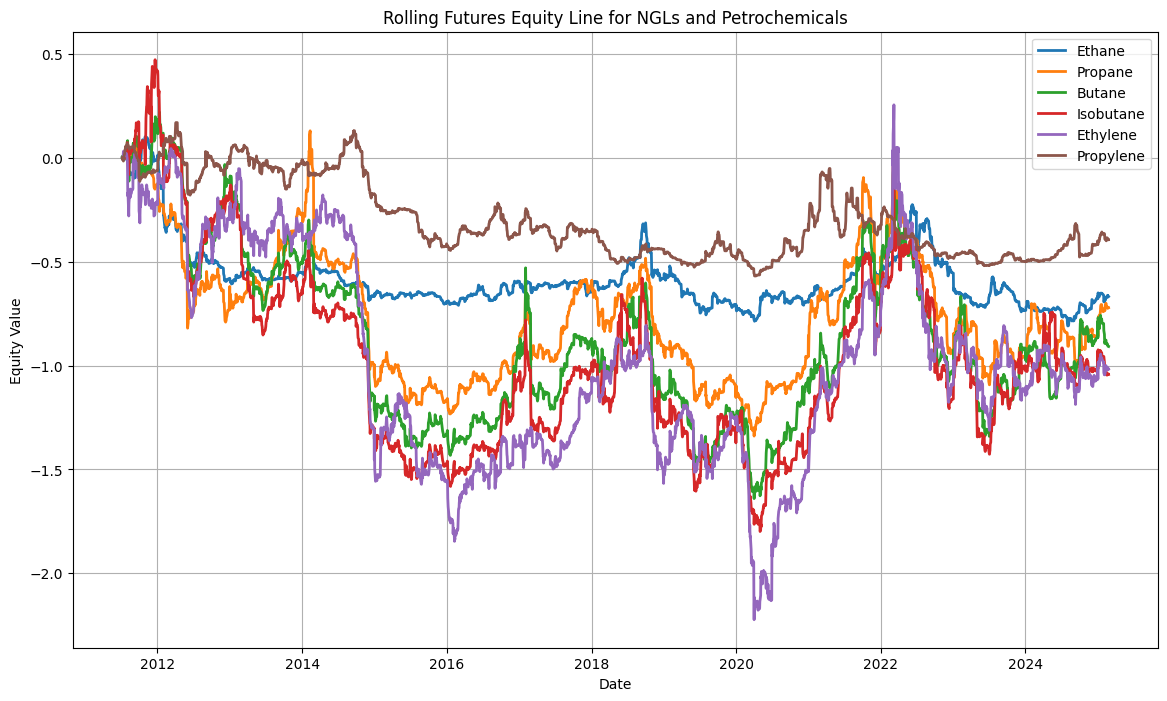

,Sheet,Rolling Futures PnL,Total Transaction Costs
0,CAP,-66793.0,11700.0
1,BAP,-72183.0,11700.0
2,DAE,-90842.0,11700.0
3,IBD,-104305.0,11700.0
4,MMB,-101797.0,11700.0
5,PCW,-39443.0,11700.0


In [51]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd

# ----------------------------
# Load and Clean NGL Data (All Contracts)
# ----------------------------

def load_ngl_data(filepath):
    xl = pd.ExcelFile(filepath)
    sheets = xl.sheet_names
    print(f"Available Sheets: {sheets}")
    
    ngl_data = {}
    for sheet in sheets:
        df = xl.parse(sheet, header=4)
        df = df.rename(columns={df.columns[0]: 'Date'})
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        df = df.dropna(subset=['Date'])
        df = df.loc[:, ~df.columns.duplicated()]
        ngl_data[sheet] = df
    
    return ngl_data

# ----------------------------
# Define EOM Roll Calendar
# ----------------------------

def define_eom_roll_calendar(df):
    df['Roll'] = (df['Date'] == (df['Date'] + MonthEnd(0))).astype(int)
    df['Action'] = 'Hold'
    df.loc[df.index[0], 'Action'] = 'Buy'
    df.loc[df['Roll'] == 1, 'Action'] = 'Sell & Buy'
    df.loc[df.index[-1], 'Action'] = 'Sell'
    return df

# ----------------------------
# Calculate EOM Rolling Futures (Dynamically Across Contracts)
# ----------------------------

def calculate_eom_rolling_futures(df, transaction_cost=0.001):
    contract_cols = [col for col in df.columns if col not in ['Date', 'Roll', 'Action']]
    
    rolling_futures = []
    cumulative_costs = []
    total_cost = 0

    # Initialize using the first contract value
    initial_value = df[contract_cols[0]].iloc[0]
    
    for idx in range(len(df)):
        t_cost = transaction_cost if idx == 0 or df.loc[idx, 'Roll'] == 1 else 0
        
        current_value = df[contract_cols[0]].iloc[idx] if df.loc[idx, 'Roll'] == 0 else df[contract_cols[1]].iloc[idx]
        
        # Calculate adjusted equity value starting from zero
        adjusted_value = current_value - initial_value - total_cost
        rolling_futures.append(adjusted_value)
        
        # Update transaction costs
        total_cost += t_cost
        cumulative_costs.append(total_cost)

    df['Rolling Futures'] = rolling_futures
    df['Cumulative Transaction Costs'] = cumulative_costs

    return df

# ----------------------------
# Metrics and Panel Plotting
# ----------------------------

def calculate_metrics(df, sheet_name):
    first_value = df['Rolling Futures'].iloc[0]
    last_value = df['Rolling Futures'].iloc[-1]
    
    pnl = (last_value - first_value) * 100 * 1000
    total_costs = df['Cumulative Transaction Costs'].iloc[-1] * 100 * 1000
    
    metrics = {
        'Sheet': sheet_name,
        'Rolling Futures PnL': pnl,
        'Total Transaction Costs': total_costs
    }

    return metrics

def plot_rolling_futures_panel(datasets, name_mapping):
    plt.figure(figsize=(14, 8))
    for ticker, df in datasets.items():
        label = name_mapping.get(ticker, ticker)
        plt.plot(df['Date'], df['Rolling Futures'], label=label, linewidth=2)

    plt.xlabel('Date')
    plt.ylabel('Equity Value')
    plt.title('Rolling Futures Equity Line for NGLs and Petrochemicals')
    plt.legend()
    plt.grid(True)
    plt.show()

# ----------------------------
# Execute Full Process
# ----------------------------

ngl_filepath = '/Users/markbogorad/Desktop/NYU_MFE/Semester_2/1.2_Trading_Energy_Derivatives_MATH_GA_2800/Oil_Project/Systematic_Energy_Trading/Data/NGLs.xlsx'
ngl_datasets = load_ngl_data(ngl_filepath)

# Correct mapping from ticker to commodity names
ticker_to_commodity = {
    'CAP': 'Ethane',
    'BAP': 'Propane',
    'DAE': 'Butane',
    'IBD': 'Isobutane',
    'MMB': 'Ethylene',
    'PCW': 'Propylene'
}

filtered_datasets = {ticker: df for ticker, df in ngl_datasets.items() if ticker in ticker_to_commodity}

all_metrics = []

for name, df in filtered_datasets.items():
    df = define_eom_roll_calendar(df)
    df = calculate_eom_rolling_futures(df, transaction_cost=0.001)
    metrics = calculate_metrics(df, name)
    all_metrics.append(metrics)

# Plot all commodities in a single panel with correct labels
plot_rolling_futures_panel(filtered_datasets, ticker_to_commodity)

# Convert and display metrics DataFrame
metrics_df = pd.DataFrame(all_metrics)
display(metrics_df)

# Optional: Save metrics to CSV
# metrics_df.to_csv('ngl_metrics_summary.csv', index=False)
